In [23]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pandas as pd

from collab.foraging import central_park_birds as cpb
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

root = find_repo_root()


# the smoke test code is to test that the code runs without error
# when the repository is updated 
# can be ignored by the reader
smoke_test = True if "CI" in os.environ else False
frames = 150 if smoke_test else 300
frames_sps = 150 if smoke_test else 2300
sampling_rate = 0.001 if smoke_test else 0.02

notebook_starts = time.time()

In [24]:
ducks_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)
sparrows_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)

ducks_raw = ducks_raw.rename(columns={"bird": "forager"})
sparrows_raw = sparrows_raw.rename(columns={"bird": "forager"})

In [26]:
# frame numbers differ to obtain dataset sizes in the same ballparks

ducks_sub = ft.subset_frames_evenly_spaced(ducks_raw, frames)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_obj = ft.object_from_data(
    ducks_sub, grid_size=90, frames=frames, calculate_step_size_max=True
)

sps_sub = ft.subset_frames_evenly_spaced(sparrows_raw, frames_sps)
sps_sub = sps_sub[sps_sub["time"] <= 800]
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_obj = ft.object_from_data(
    sps_sub, grid_size=90, frames=frames_sps, calculate_step_size_max=True
)

original_frames: 1450
original_shape: (8867, 4)
resulting_frames: 300
resulting_shape: (1858, 4)
min_time 1
max_time 300
original_frames: 11549
original_shape: (22821, 4)
resulting_frames: 2300
resulting_shape: (4562, 4)
min_time 1
max_time 2300


In [15]:
# these are max shifts along an axis
# sparrows et al. seem more jumpy
print(ducks_obj.step_size_max)
print(sps_obj.step_size_max)

6.0
25.0


In [16]:
# let's get a feel for the distance distributions
duck_distances = ft.foragers_to_forager_distances(ducks_obj)
sps_distances = ft.foragers_to_forager_distances(sps_obj)

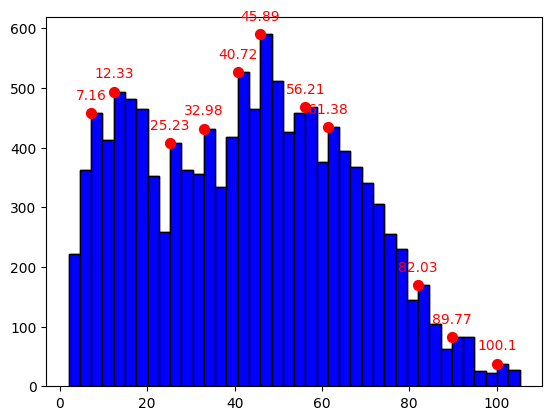

In [17]:
# ducks
ft.distances_and_peaks(duck_distances)

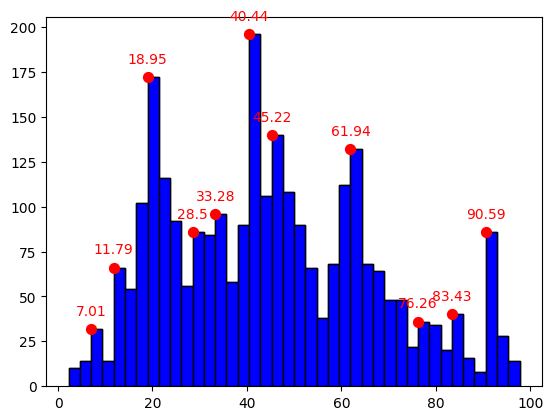

In [18]:
# now sparrows et al.
ft.distances_and_peaks(sps_distances)

# for instance, it seems that as a proximity parameter setting
# 19 should work well for sparrows, less so ducks
# 46 should work well for ducks, not terribly for sparrows
# 85 should not work very well for either

# later one we'll have nicer plots of distances,
# these are useful b/c they numerically identify the peaks

In [27]:
# note we're severely subsampling the grid here, mostly for speed

ducks_vis = cpb.cp_generate_visibility(ducks_obj.foragers, sampling_rate=sampling_rate)
ducks_obj.visibility = ducks_vis["visibility"]
ducks_obj.visibilityDF = ducks_vis["visibilityDF"]

sps_vis = cpb.cp_generate_visibility(sps_obj.foragers, sampling_rate=sampling_rate)
sps_obj.visibility = sps_vis["visibility"]
sps_obj.visibilityDF = sps_vis["visibilityDF"]

In [28]:
path = os.path.join(
    root, "data/foraging/central_park_birds_cleaned_2022/central_park_objects.pkl"
)
if not os.path.exists(path):
    test_me = [10, 20, 30, 40, 50, 60, 70, 80]  # [19, 46, 85]
    ducks_objects = cpb.cp_derive(ducks_obj, test_me, duck_distances)
    sps_objects = cpb.cp_derive_sps(sps_obj, test_me, sps_distances)
    central_park_objects = [ducks_objects, sps_objects]
    with open(path, "wb") as file:
        dill.dump(central_park_objects, file)

# these will be used for inference later

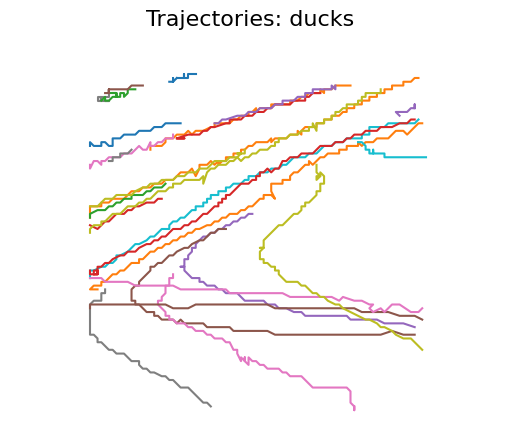

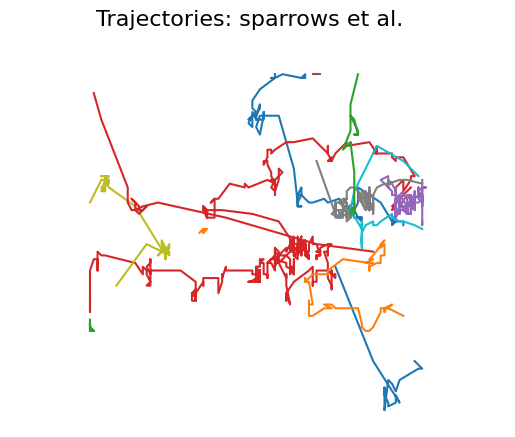

In [29]:
fig = ft.plot_trajectories(ducks_obj.foragersDF, "ducks")
fig.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_ducks.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

plt = ft.plot_trajectories(sps_obj.foragersDF, "sparrows et al.")
plt.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_sps.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

In [22]:
fig = ft.plot_distances(sps_distances, "sparrows et al.")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_sps.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

fig = ft.plot_distances(duck_distances, "ducks")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_ducks.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

notebook_ends = time.time()

print(
    f"notebook took {notebook_ends - notebook_starts} seconds, {(notebook_ends - notebook_starts)/60} minutes to run"
)

notebook took 12.232292175292969 seconds, 0.2038715362548828 minutes to run
